# Processing admixture array sites for SLiM simulations

Links:

* info about different coordinate types: https://groups.google.com/forum/#!msg/biomart-users/OtQbAx3y9CA/wrF19ID1AgAJ
* https://www.biostars.org/p/2005/
* http://www.bioconductor.org/packages/release/bioc/vignettes/biomaRt/inst/doc/biomaRt.html#attribute-pages
* http://www.ensembl.org/info/data/biomart/biomart_r_package.html
* http://www.ensembl.info/blog/2015/06/01/biomart-or-how-to-access-the-ensembl-data-from-r/
* for checking with manually downloaded data: http://www.ensembl.org/info/data/biomart/how_to_use_biomart.html
* biotypes FAQ: http://www.ensembl.org/Help/Glossary

Following [this](http://www.ensembl.org/info/data/biomart/biomart_r_package.html) tutorial, I want to extract coordinates of exonic and regulatory regions from the Ensembl database and then calculate the density of such regions in a defined window around each SNP.

These densities will they be used as predictors in a linear model, predicting the Nea. ancestry at each site.

Alternatively, I could just test if the distribution of densities for different regions differ based on frequency of Nea. alleles at each site.

# Fetch coordinates of different genomic regions

In [1]:
suppressMessages(suppressWarnings({
    library(biomaRt)
    library(rtracklayer)
    library(BSgenome.Hsapiens.UCSC.hg19)
}))

In [2]:
suppressMessages(suppressWarnings({
    library(tidyverse)
    library(stringr)
    library(magrittr)
    library(here)
    library(bdkn)
    library(admixr)
}))

In [3]:
load("../data/RData/introgression_predictors.RData")

The saved random seed did not (for whatever reason) work in reproducing the random re-sampling of positions of neutral "gap markers". However, we can save the sampled vector (0s and 1s generated in a re-sampling step) and use it instead of the re-sampling command bellow. That way everything remains reproducible.

In [4]:
gap_markers <- tbl$hits_gap

In [5]:
regions <- list()

## Protein coding and UTR coordinates

Show all the available biomarts for hg19:

In [6]:
listMarts(host="grch37.ensembl.org")

biomart,version
ENSEMBL_MART_ENSEMBL,Ensembl Genes 91
ENSEMBL_MART_SNP,Ensembl Variation 91
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 91


Connect to the human gene Ensembl dataset:

In [7]:
ensembl_mart_genes <- useMart("ENSEMBL_MART_ENSEMBL", host="grch37.ensembl.org")
listDatasets(ensembl_mart_genes) %>% filter(str_detect(dataset, "sapiens"))

dataset,description,version
hsapiens_gene_ensembl,Human genes (GRCh37.p13),GRCh37.p13


In [8]:
genes <- useDataset(dataset="hsapiens_gene_ensembl", mart=ensembl_mart_genes)

### Protein coding coordinates

In [9]:
regions[["protein_coding"]] <-
    getBM(c("chromosome_name", "genomic_coding_start", "genomic_coding_end"),
          filters=c("chromosome_name", "biotype"),  # filter for chromosome and biotype
          values=list(1:22, "protein_coding"),      # (chromosomes 1:22 and "protein_coding")
          mart=genes) %>%
    filter(complete.cases(.)) %>%
    select(chrom=chromosome_name, start=genomic_coding_start, end=genomic_coding_end) %>%
    arrange(chrom, start) %>%
    makeGRangesFromDataFrame %>%
    IRanges::reduce()

In [10]:
sum(width(regions[["protein_coding"]]))

[1] 33844885

### UTRs


More on the UTR vs protein_coding sizes in humans:
* http://seqanswers.com/forums/showthread.php?p=34995#post34995
* http://www.nature.com/nature/journal/v461/n7261/full/nature08250.html


Also: https://groups.google.com/forum/#!topic/biomart-users/OtQbAx3y9CA

#### 5' UTR

In [11]:
regions[["utr5"]] <-
    getBM(c("chromosome_name", "5_utr_start", "5_utr_end"),
          filters=c("chromosome_name", "biotype"),  # filter for chromosome and biotype
          values=list(1:22, "protein_coding"),      # (chromosomes 1:22 and "protein_coding")
          mart=genes) %>%
    filter(complete.cases(.)) %>%
    setNames(c("chrom", "start", "end")) %>% 
    arrange(chrom, start) %>%
    makeGRangesFromDataFrame %>%
    IRanges::reduce()

In [12]:
sum(width(regions[["utr5"]]))

[1] 10336680

#### 3' UTR

In [13]:
regions[["utr3"]] <-
    getBM(c("chromosome_name", "3_utr_start", "3_utr_end"),
          filters=c("chromosome_name", "biotype"),  # filter for chromosome and biotype
          values=list(1:22, "protein_coding"),      # (chromosomes 1:22 and "protein_coding")
          mart=genes) %>%
    filter(complete.cases(.)) %>%
    setNames(c("chrom", "start", "end")) %>% 
    arrange(chrom, start) %>%
    makeGRangesFromDataFrame %>%
    IRanges::reduce()

In [14]:
sum(width(regions[["utr3"]]))

[1] 37469434

### Exons

In [15]:
regions[["exon"]] <- IRanges::reduce(c(regions[["protein_coding"]], regions[["utr5"]], regions[["utr3"]]))

## Get the coordinates of 5kb upstream of transcription start site

Make sure to correctly handle 5k upstream (on the fwd strand) ond 5k downstream (ond the rev strand) from the TSS.

In [16]:
listFilters(genes) %>% filter(str_detect(name, "biotype"))

name,description
biotype,Type
transcript_biotype,Transcript Type


In [17]:
tss <-
    getBM(c("chromosome_name", "transcription_start_site", "strand"),
          filters=c("chromosome_name", "transcript_biotype"),
          values=list(1:22, "protein_coding"),
          mart=genes) %>%
    setNames(c("chrom", "pos", "strand")) %>% 
    mutate(strand=ifelse(strand == 1, "-", "+")) %>% 
    arrange(chrom, pos) %>%
    makeGRangesFromDataFrame(start.field="pos", end.field="pos")

In [18]:
regions[["tss_5k"]] <- resize(tss, width=5001)
strand(regions[["tss_5k"]]) <- "*"
regions[["tss_5k"]] %<>% IRanges::reduce()

In [19]:
i <- 1:2
head(tss)[i]
regions[["tss_5k"]][i]

GRanges object with 2 ranges and 0 metadata columns:
      seqnames           ranges strand
         <Rle>        <IRanges>  <Rle>
  [1]        1 [ 69091,  69091]      -
  [2]        1 [139379, 139379]      +
  -------
  seqinfo: 22 sequences from an unspecified genome; no seqlengths

GRanges object with 2 ranges and 0 metadata columns:
      seqnames           ranges strand
         <Rle>        <IRanges>  <Rle>
  [1]        1 [ 64091,  69091]      *
  [2]        1 [139379, 144379]      *
  -------
  seqinfo: 22 sequences from an unspecified genome; no seqlengths

## Coordinates of regulatory features

It took forever to find out, how to get the regulatory features. In the end I found it totally by accident in some bugreport mail :( https://support.bioconductor.org/p/39545/

Show all the available biomarts for hg19:

In [20]:
listMarts(host="grch37.ensembl.org")

biomart,version
ENSEMBL_MART_ENSEMBL,Ensembl Genes 91
ENSEMBL_MART_SNP,Ensembl Variation 91
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 91


Connect to the human gene Ensembl dataset:

In [21]:
ensembl_mart_funcgen <- useMart("ENSEMBL_MART_FUNCGEN", host="grch37.ensembl.org")
listDatasets(ensembl_mart_funcgen) %>% filter(str_detect(dataset, "sapiens"))

dataset,description,version
hsapiens_annotated_feature,Human Regulatory Evidence (GRCh37.p13),GRCh37.p13
hsapiens_motif_feature,Human Binding Motifs (GRCh37.p13),GRCh37.p13
hsapiens_mirna_target_feature,Human miRNA Target Regions (GRCh37.p13),GRCh37.p13
hsapiens_external_feature,Human Other Regulatory Regions (GRCh37.p13),GRCh37.p13
hsapiens_regulatory_feature,Human Regulatory Features (GRCh37.p13),GRCh37.p13


In [22]:
regulation <- useDataset(dataset="hsapiens_regulatory_feature", mart=ensembl_mart_funcgen)

Download the dataframe from Biomart:

In [23]:
regulatory_features_df <-
    getBM(attributes=c("chromosome_name", "chromosome_start", "chromosome_end", "feature_type_name"),
          filters="chromosome_name",
          values=1:22,
          mart=regulation) %>%
    setNames(c("chrom", "start", "end", "feature")) %>%
    mutate(feature=str_replace_all(tolower(feature), " ", "_"),
           feature=str_replace(feature, "flanking_region", "flank"))

In [24]:
table(regulatory_features_df$feature)


ctcf_binding_site          enhancer    open_chromatin          promoter 
            55194             27577            107233             14287 
   promoter_flank   tf_binding_site 
            45496             22376 

In [25]:
regions <- c(regions, lapply(split(regulatory_features_df, regulatory_features_df$feature),
                             function(df) {
                                 IRanges::reduce(makeGRangesFromDataFrame(df))
                             }))

## Coordinates of primate phastCons elements

How to retrieve them: https://support.bioconductor.org/p/25587/

Per-base vs elements diference: https://www.biostars.org/p/2129/#2143

In [26]:
library(rtracklayer)

In [27]:
session <- browserSession()
genome(session) <- "hg19"

In [28]:
query <- ucscTableQuery(session, "cons46way", GRangesForUCSCGenome("hg19", chrom=paste0("chr", 1:22)))

In [29]:
tableNames(query)

[1] "phyloP46wayPrimates"             "phyloP46wayPlacental"           
 [3] "phyloP46wayAll"                  "phastCons46wayPrimates"         
 [5] "phastCons46wayPlacental"         "phastCons46way"                 
 [7] "phastConsElements46wayPrimates"  "phastConsElements46wayPlacental"
 [9] "phastConsElements46way"          "multiz46way"

In [30]:
tableName(query) <- "phastConsElements46wayPrimates"

In [31]:
regions[["priPhastCons"]] <-
    getTable(query) %>%
    select(-bin, -name, -score) %>%
    makeGRangesFromDataFrame(starts.in.df.are.0based=TRUE) %>%
    .[seqnames(.) %in% paste0("chr", 1:22)]
seqlevels(regions[["priPhastCons"]]) <- paste0("chr", 1:22)

## Reduce all regions and convert their coordinates to UCSC hg19

Convert all coordinate dataframes into individual `GRanges` objects:

In [32]:
regions <- lapply(regions,
                  function(r) {
                      reduced_r <- IRanges::reduce(r)
                      seqlevelsStyle(reduced_r) <- "UCSC"
                      seqinfo(reduced_r) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)
                      
                      reduced_r
                  })

### Combined promoter + protein coding regions (for simulating different selection for both classes - Figure 4)

The problem is that both are overlapping, so we need to take care of that first and work with only non-overlapping sequence:

In [5]:
uniq_cds <- regions$protein[regions$protein %outside% regions$promoter]

In [6]:
regions[["merged"]] <- IRanges::union(uniq_cds, regions$promoter)

## Get coordinates of "gaps" (all putatively non-functional regions)

First get the reduce set of annotated regions (everything mashed together):

In [34]:
(all_regions <- unlist(GRangesList(regions)) %>% IRanges::reduce() %>% sort)

GRanges object with 751323 ranges and 0 metadata columns:
           seqnames               ranges strand
              <Rle>            <IRanges>  <Rle>
       [1]     chr1       [ 9880, 10734]      *
       [2]     chr1       [11001, 11800]      *
       [3]     chr1       [13371, 13724]      *
       [4]     chr1       [13908, 14498]      *
       [5]     chr1       [15462, 15778]      *
       ...      ...                  ...    ...
  [751319]    chr22 [51221197, 51227091]      *
  [751320]    chr22 [51231014, 51231196]      *
  [751321]    chr22 [51235000, 51235201]      *
  [751322]    chr22 [51237212, 51237544]      *
  [751323]    chr22 [51239150, 51239664]      *
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

Get lengths of all hg19 chromosomes:

In [35]:
hg19 <- GRanges(seqinfo(BSgenome.Hsapiens.UCSC.hg19))
hg19 <- hg19[seqnames(hg19) %in% paste0("chr", 1:22)]

Everything in hg19 that is not in the annotated set of functional regions is a gap or "junk":

In [36]:
regions[["gap"]] <- IRanges::setdiff(hg19, all_regions) %>% IRanges::reduce() %>% sort

### Total amount of sequence in each genomic region

In [7]:
tibble(
    region=names(regions),
    length=sapply(regions, function(r) { sum(as.numeric(width(IRanges::reduce(r))))} ) / 1e6
) %>% arrange(length)

region,length
utr5,10.33668
tf_binding_site,10.48753
enhancer,18.27491
promoter,22.68667
protein_coding,33.84488
utr3,37.46943
ctcf_binding_site,41.23060
open_chromatin,51.20425
merged,54.42362
promoter_flank,59.75196


<br><br><br><br><br><br><br><br><br><br>

## Get coordinates of admixture array sites

* Add intergenic regions too - actually, regions are not necessary, just takes SNPs that don't overlap anything.
* Check how many admixture array sites fall within each functional region.

In [8]:
source("../code/utils.R")

In [9]:
suppressMessages({

# load the sample information
sgdp <- load_sgdp_info("../data/10_24_2014_SGDP_metainformation_update.txt") %>%
    filter(! Region %in% c("Africa", "Oceania")) %>%
    dplyr::select(-Country, -Latitude, -Longitude, pop=Region) %>%
    mutate(age=0) %>%
    group_by(name, age, pop) %>%
    ungroup
emhs <- read_delim("../data/emh_ages.txt", delim=" ", col_names=c("name", "age")) %>%
    mutate(name=str_replace(name, "-", "_"), pop="EMH", Latitude=NA, Longitude=NA) %>%
    filter(name != "Oase1")
samples <- bind_rows(emhs, sgdp)

# load genotypes at archaic admixture sites
genotypes <-
    load_dataset("../data/genotypes/ice_age.tsv",
                 "../data/genotypes/sgdp.tsv",
                 "../data/genotypes/archaics.tsv",
                 random_sample=FALSE) %>%
    select(c("chrom", "pos", sgdp$name)) %>%
    mutate(start=pos, end=pos) %>%
    select(-pos) %>%
    makeGRangesFromDataFrame(keep.extra.columns=TRUE)

})

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

In [10]:
seqlevelsStyle(genotypes) <- "UCSC"
seqinfo(genotypes) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)

## Fetch a B value at each site

There are some sites that don't have a B value available or that have other B value-related problems. The shenanigans bellow deal with that. In short, we want to have the same # of sites in the `sites` and `genotypes` objects.

In [11]:
source("../code/assign_bvals.R")


Attaching package: ‘BSgenome.Hsapiens.UCSC.hg18’

The following object is masked from ‘package:BSgenome.Hsapiens.UCSC.hg19’:

    Hsapiens



Annotate the GRanges genotype object:

In [12]:
genotypes <- assign_bvals(genotypes, bval_path="../data/bkgd/", chain_path="../data/hg18ToHg19.over.chain")

Create a separate `GRanges` object for annotations only:

In [13]:
sites <- granges(genotypes)
sites$bval <- genotypes$bval

Remove the B value column from the genotype GRanges data:

In [14]:
genotypes$bval <- NULL

## Calculate Neanderthal allele frequency at each locus

In [15]:
freq_eur <- 1/2 * apply(mcols(genotypes)[filter(samples, pop == "WestEurasia")$name], 1, mean, na.rm=TRUE)
freq_all <- 1/2 * apply(mcols(genotypes)[filter(samples, pop != "EMH")$name], 1, mean, na.rm=TRUE)

In [16]:
mcols(sites)[["freq_eur"]] <- freq_eur
mcols(sites)[["freq_all"]] <- freq_all

In [17]:
summary(sites$freq_eur)
summary(sites$freq_all)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
0.00000 0.00000 0.00000 0.01830 0.01493 1.00000      52 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
0.00000 0.00000 0.00254 0.02044 0.02030 1.00000      52 

## Number of admixture array sites in each genomic region

In [18]:
sapply(regions, function(reg) { length(IRanges::subsetByOverlaps(sites, reg)) }) %>% sort

tf_binding_site              utr5          enhancer    protein_coding 
             2257              2391              4020              4953 
         promoter              utr3 ctcf_binding_site            merged 
             5189              6821              8518              9822 
   open_chromatin              exon    promoter_flank      priPhastCons 
            11158             13099             13208             17443 
           tss_5k               gap 
            27598            400872

## Get the hits of each site in different genomic regions

In [19]:
for (r in names(regions)) {
    col_name <- paste0("hits_", r)

    # find which sites are falling within a given region
    hits <- findOverlaps(sites, regions[[r]])

    # mark which sites hit a region
    mcols(sites)[[col_name]] <- 0
    mcols(sites[queryHits(hits)])[[col_name]] <- 1
}

Subsample the sites overlapping with gaps (it's impossible to simulate all ~400k sites in gaps):

In [20]:
gap_hits <- which(sites$hits_gap == 1)

In [21]:
table(sites$hits_gap)


     0      1 
 83044 400872 

In [22]:
sites$hits_gap <- gap_markers

In [23]:
table(sites$hits_gap)


    0     1 
83044 50000 

## Convert the final GRanges object to a normal data frame for the analyses bellow

In [24]:
tbl <- as.data.frame(sites) %>%
    select(-width, -strand) %>%
    rename(chrom=seqnames)

In [25]:
nrow(tbl)

[1] 483916

## Final number of hits per region

In [26]:
select(tbl, starts_with("hits")) %>% summarise_all(sum, na.rm=TRUE) %>% t

hits_protein_coding,4953
hits_utr5,2391
hits_utr3,6821
hits_exon,13099
hits_tss_5k,27598
hits_ctcf_binding_site,8518
hits_enhancer,4020
hits_open_chromatin,11158
hits_promoter,5189
hits_promoter_flank,13208
hits_tf_binding_site,2257


<br><br><br><br><br>

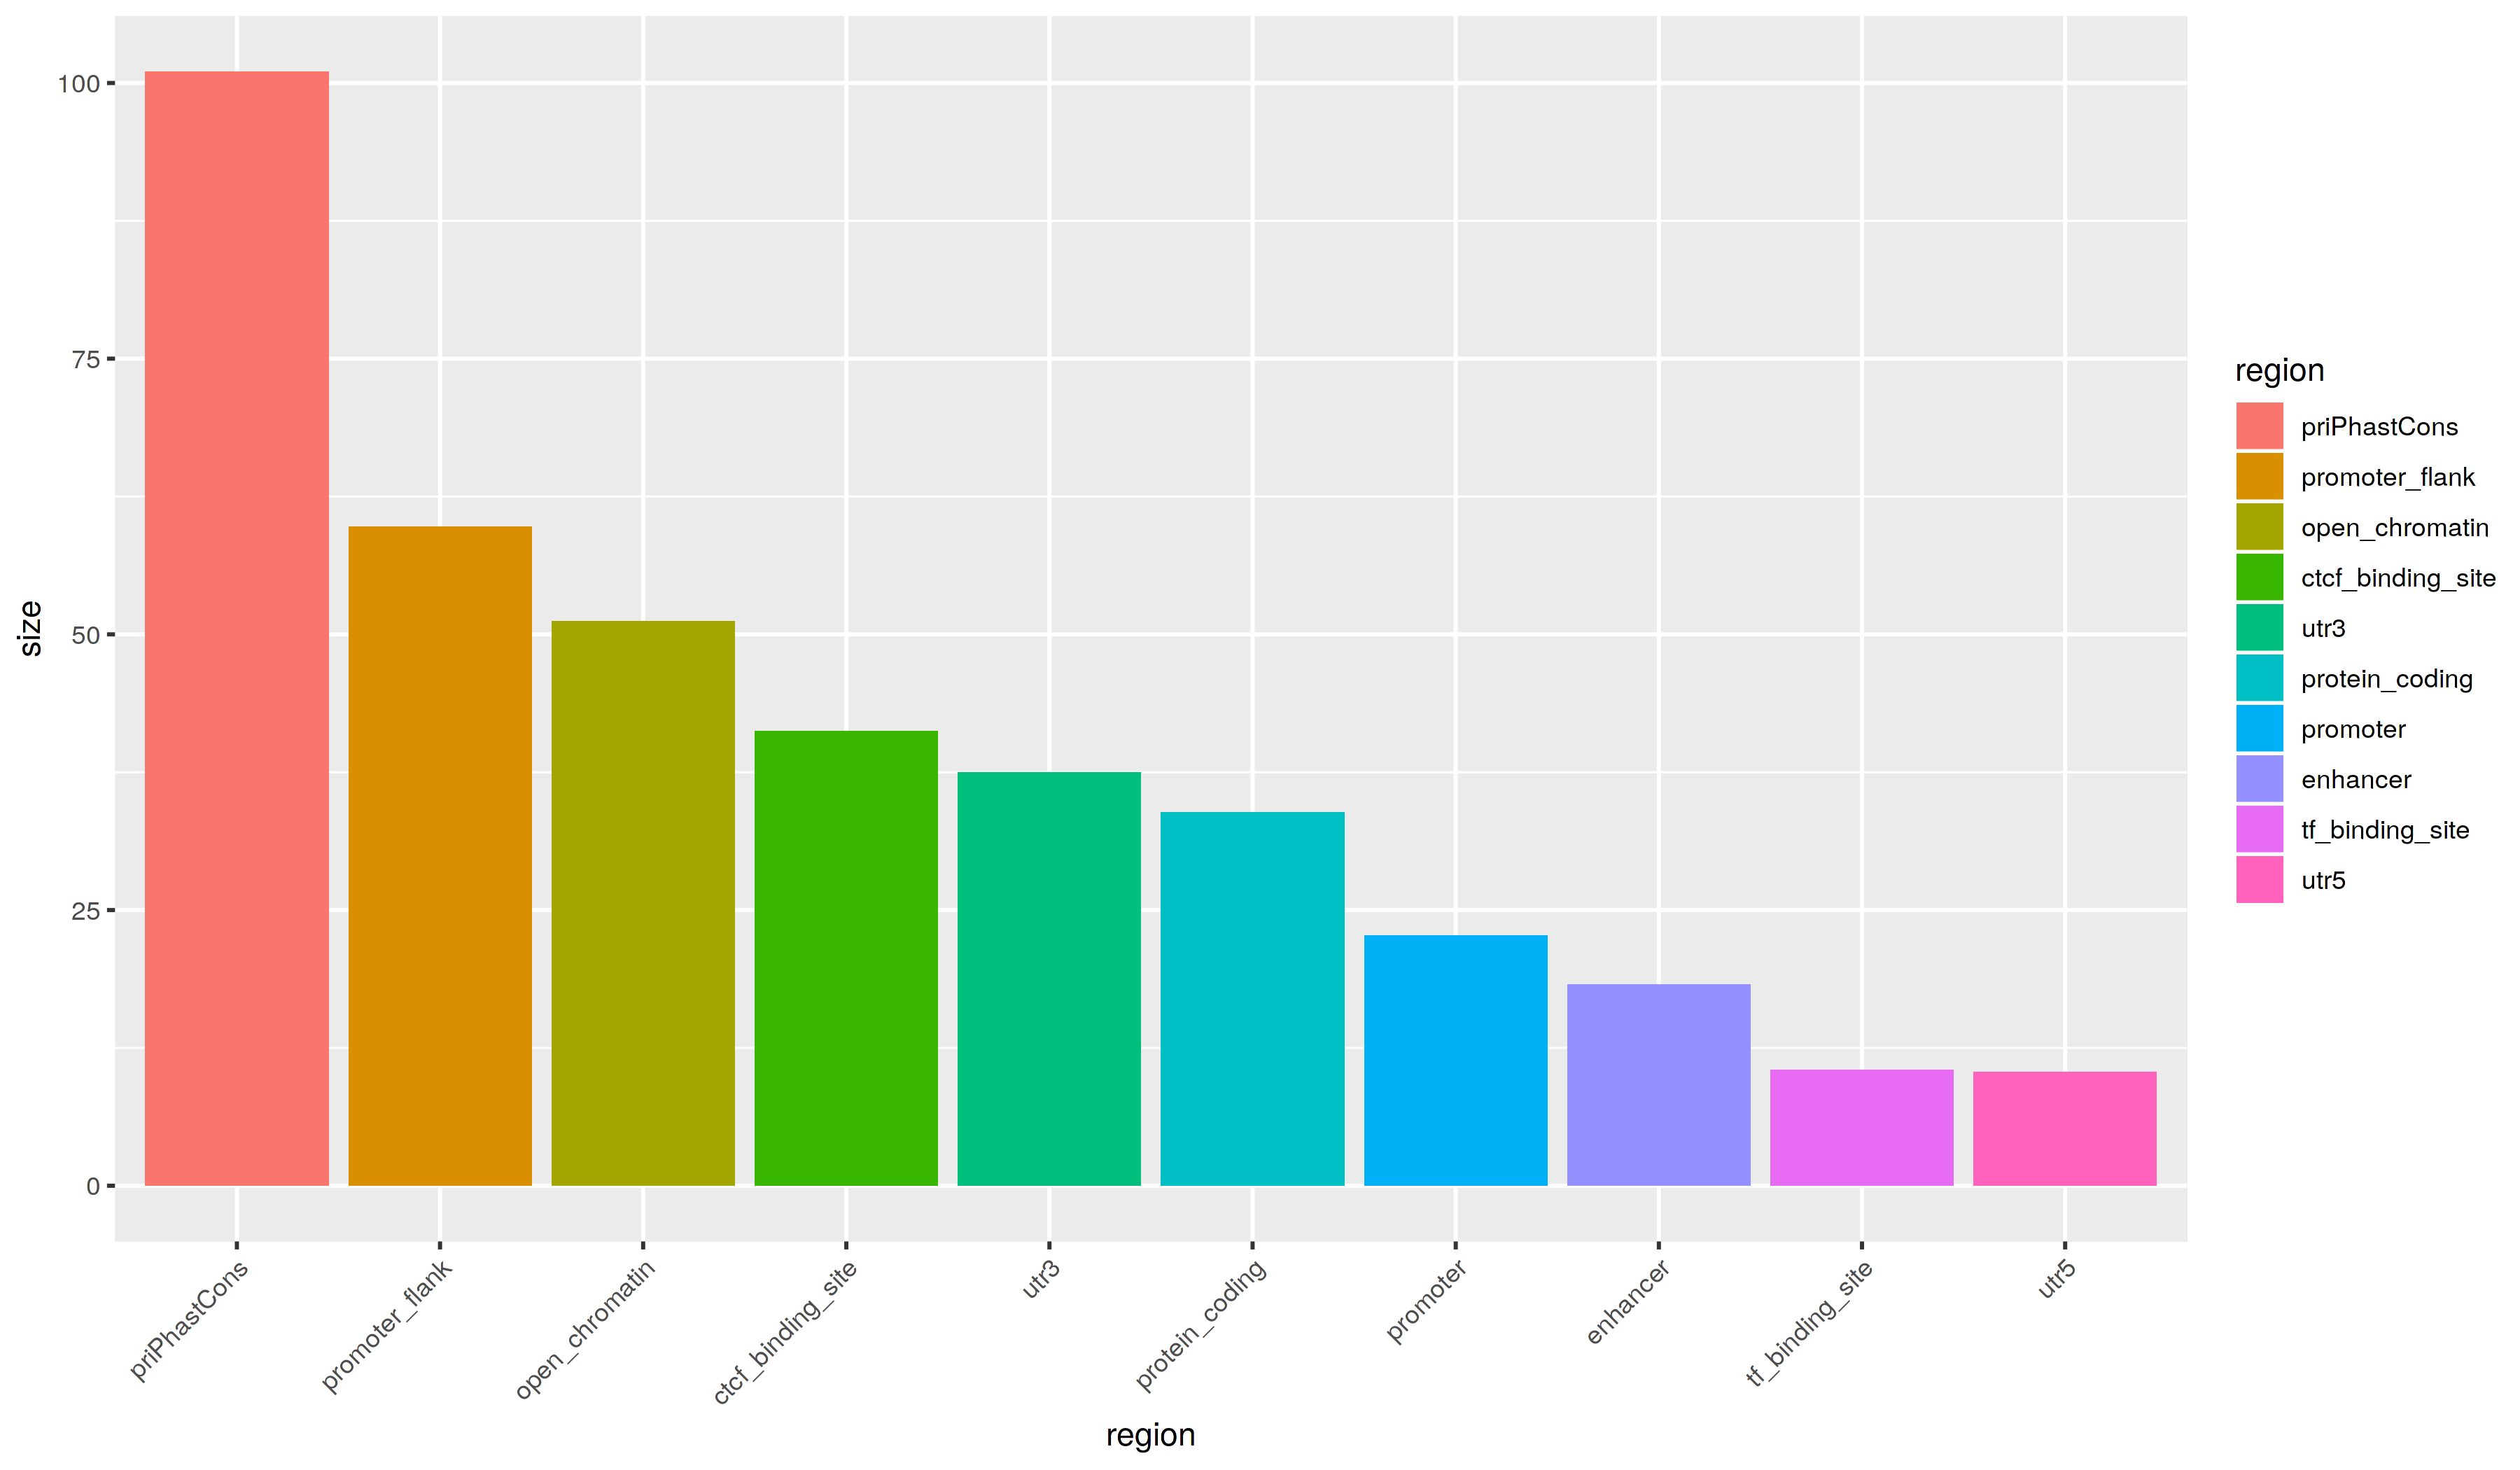

In [27]:
options(repr.plot.width=12, repr.plot.height=7, repr.plot.res=300)

sapply(setdiff(names(regions), c("exon", "merged", "gap", "tss_5k")), function(x) sum(as.numeric(width(regions[[x]]))) / 1e6) %>%
       t %>% as.data.frame %>% gather(region, size) %>%
       mutate(region=factor(region, levels=region[order(size, decreasing=TRUE)])) %>% 
       ggplot(aes(region, size, fill=region)) + geom_bar(stat="identity") +
           theme(axis.text.x = element_text(hjust=1, angle=45))

In [28]:
options(repr.plot.width=12, repr.plot.height=7, repr.plot.res=300)

sapply(names(regions), function(x) sum(as.numeric(width(regions[[x]]))) / 1e6) %>%
       t %>% as.data.frame %>% gather(region, size) %>%
       mutate(region=factor(region, levels=region[order(size, decreasing=TRUE)]))

region,size
protein_coding,33.84488
utr5,10.33668
utr3,37.46943
exon,73.95255
tss_5k,157.46965
ctcf_binding_site,41.23060
enhancer,18.27491
open_chromatin,51.20425
promoter,22.68667
promoter_flank,59.75196


<br><br><br><br><br>
## B value vs Nea. ancestry

In [29]:
bbins <- findInterval(sites$bval, quantile(sites$bval, seq(0, 1, 0.1), na.rm=TRUE), rightmost.closed=TRUE)

gt_bins <- split(genotypes, bbins)

In [30]:
sample_ids <- filter(samples, pop != "EMH")$name

In [31]:
nea_bins <- lapply(seq_along(gt_bins), function(bin_i) {
    tibble(
        nea=(gt_bins[[bin_i]] %>% as.data.frame %>% select(one_of(sample_ids)) %>% summarise_all(mean, na.rm=TRUE) %>% t %>% .[, 1]) / 2,
        name=sample_ids,
        bin=bin_i
    )
}) %>%
    bind_rows %>%
    inner_join(samples) %>%
    mutate(bin=factor(bin))

Joining, by = "name"


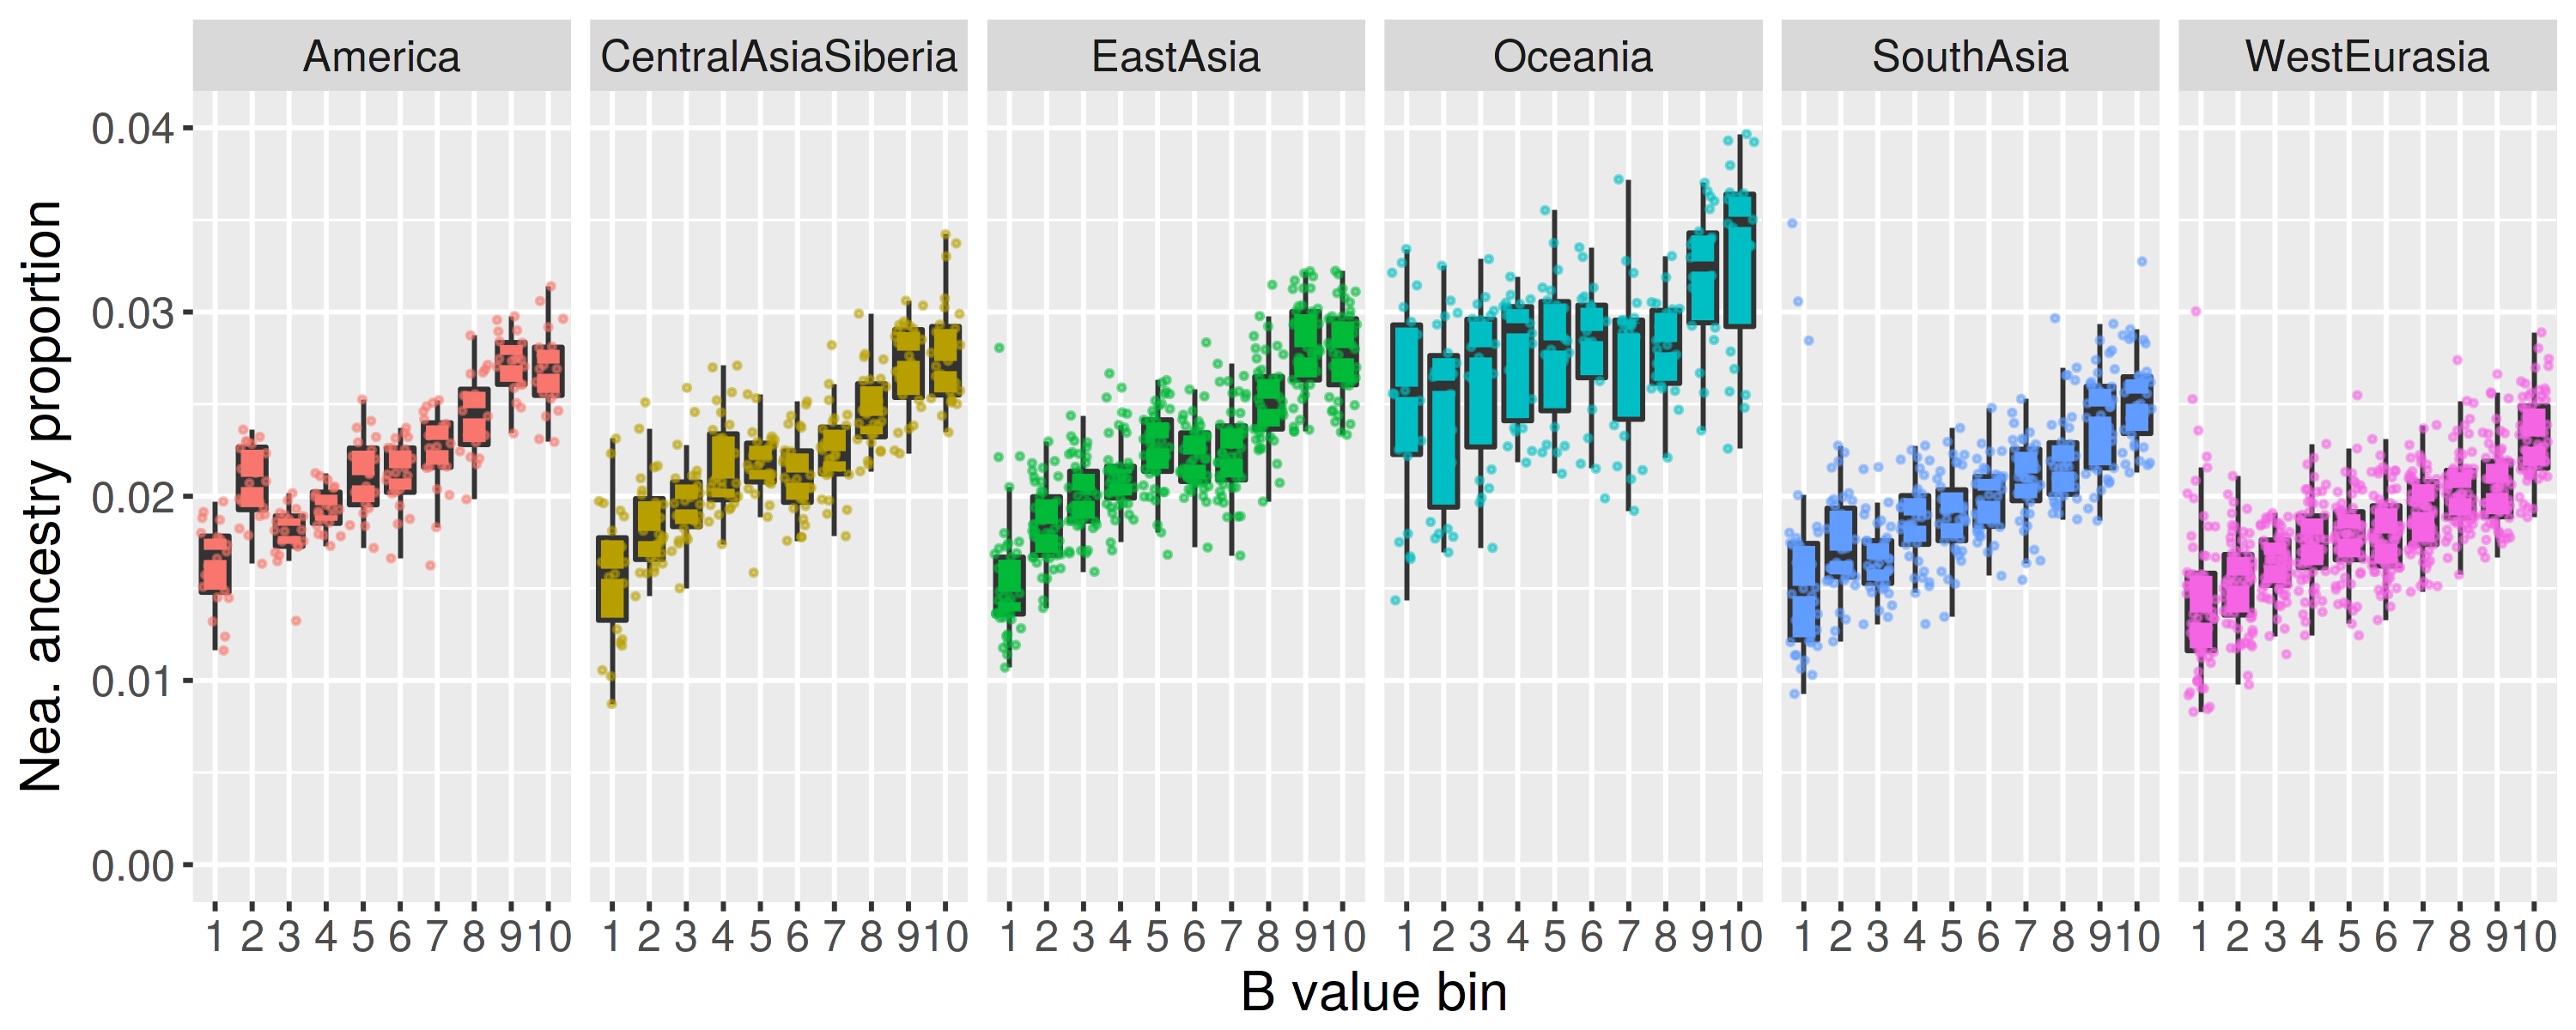

In [29]:
options(repr.plot.width=10, repr.plot.height=4, repr.plot.res=300)

nea_bins %>%
ggplot(aes(bin, nea, fill=pop, group=bin)) +
    geom_boxplot(outlier.shape=NA) +
    geom_jitter(aes(color=pop), alpha=1/2, size=1/2) +
    facet_grid(. ~ pop) +
    labs(y="Nea. ancestry proportion", x="B value bin") +
    theme(text=element_text(size=15), legend.position="none") +
    coord_cartesian(ylim=c(0, 0.04))

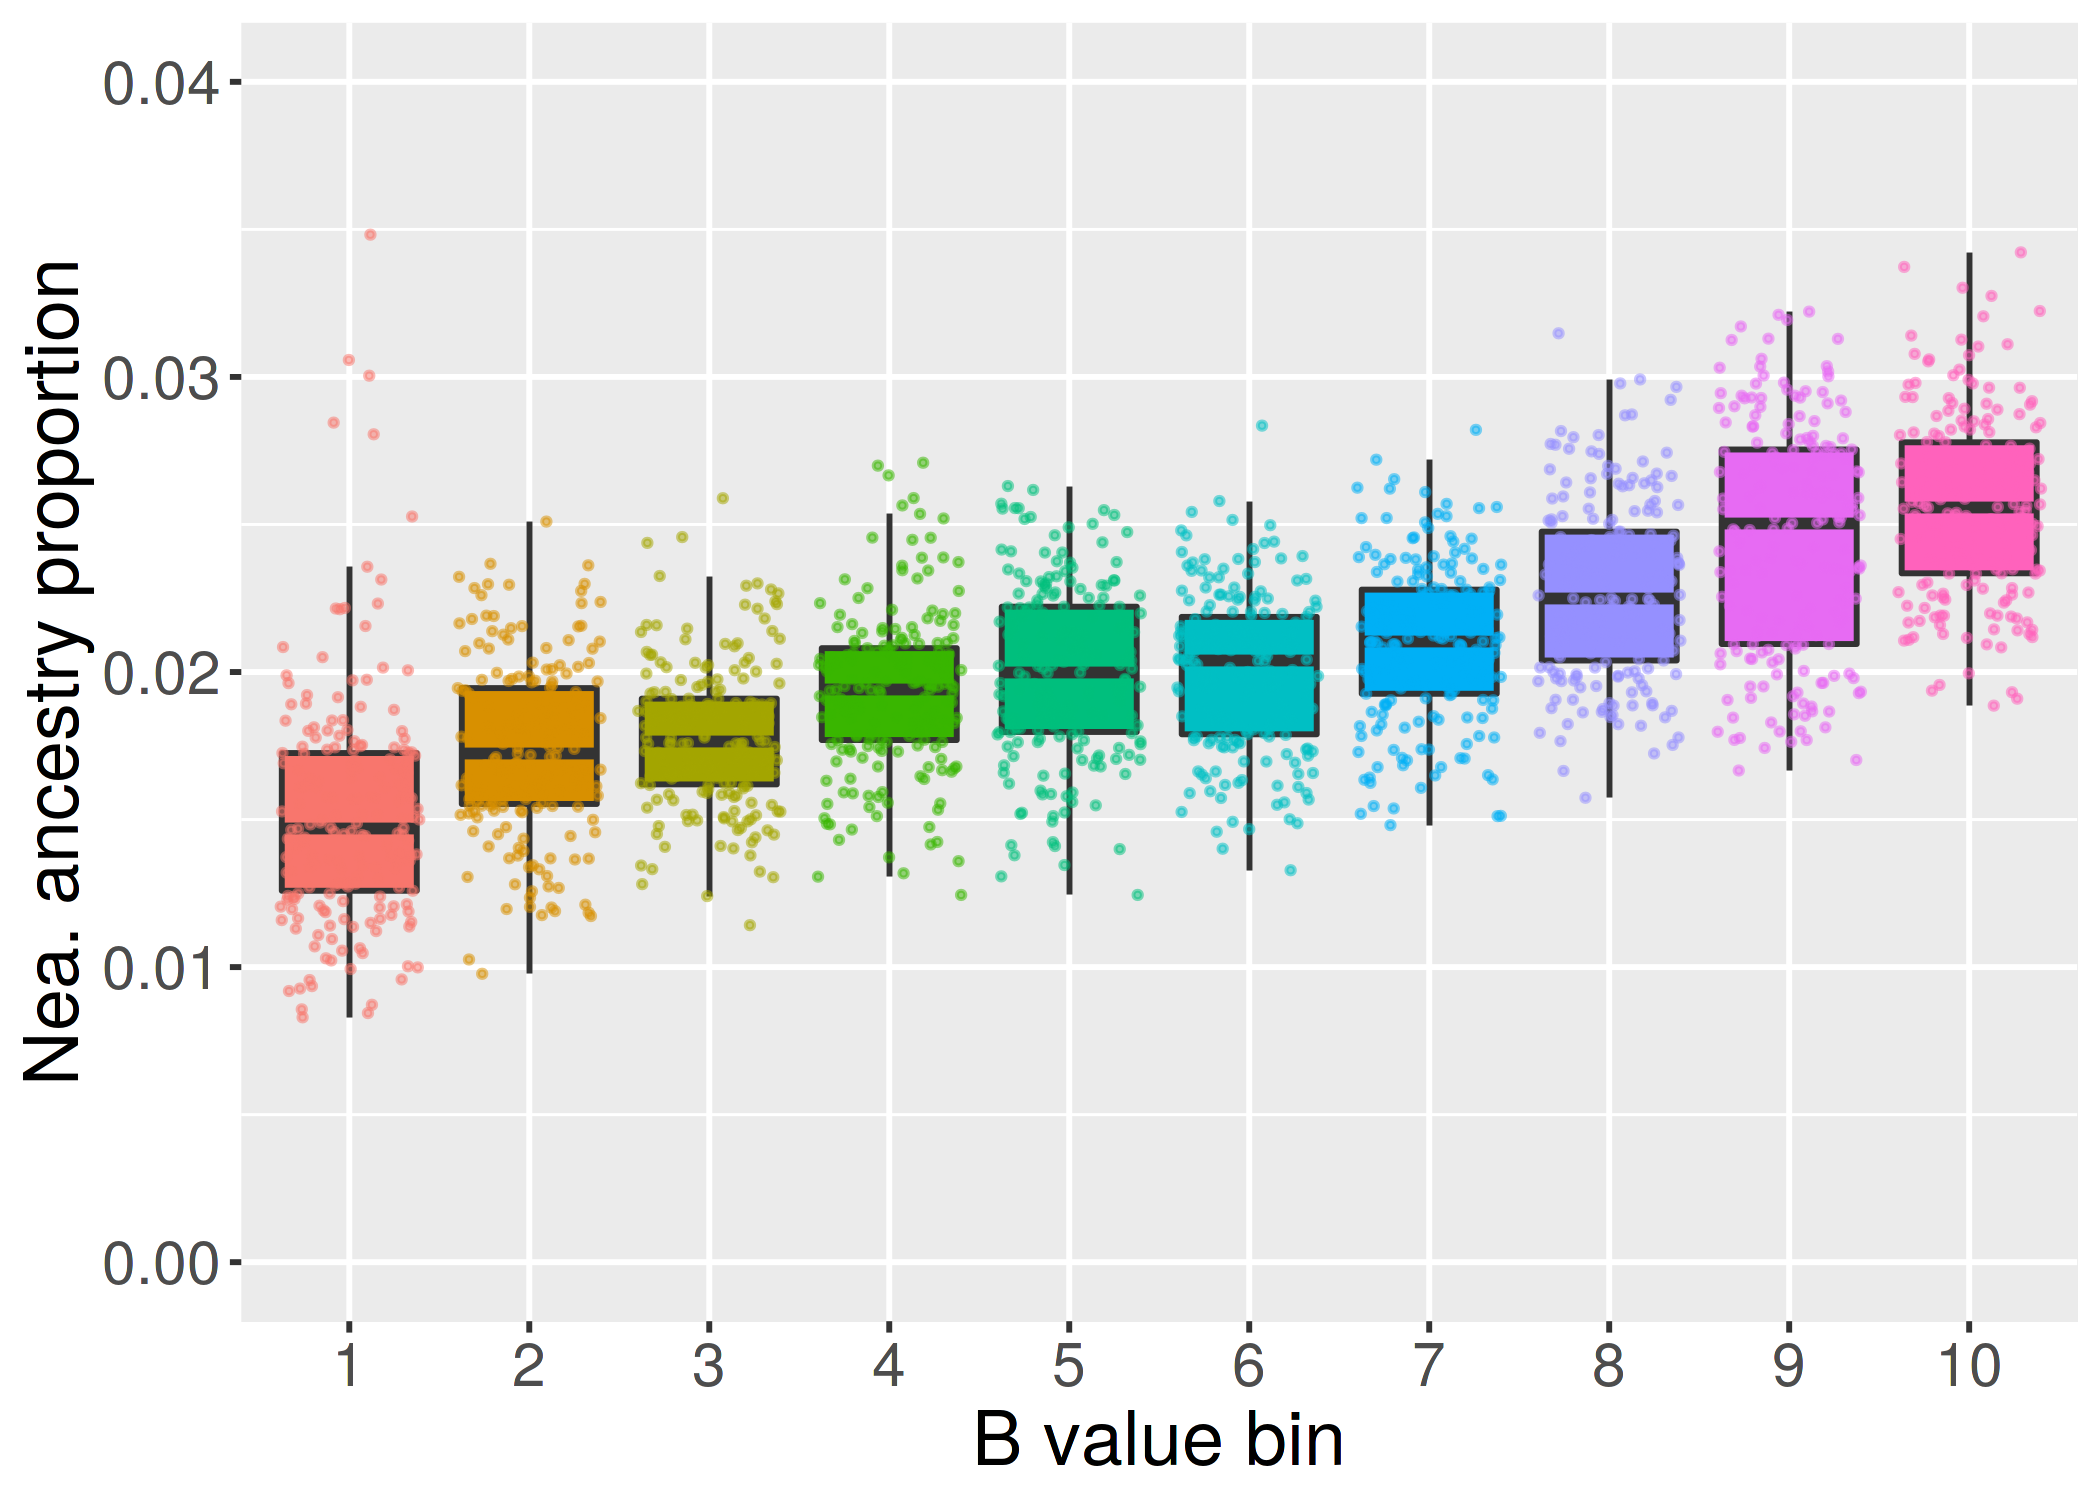

In [33]:
options(repr.plot.width=7, repr.plot.height=5, repr.plot.res=300)

nea_bins %>% filter(pop != "Oceania") %>% 
ggplot(aes(bin, nea, fill=bin, group=bin)) +
    geom_boxplot(outlier.shape=NA) +
    geom_jitter(aes(color=bin), alpha=1/2, size=1/2) +
    labs(y="Nea. ancestry proportion", x="B value bin") +
    theme(text=element_text(size=18), legend.position="none") +
    coord_cartesian(ylim=c(0, 0.04))

Warning message:
“Removed 15 rows containing non-finite values (stat_density).”

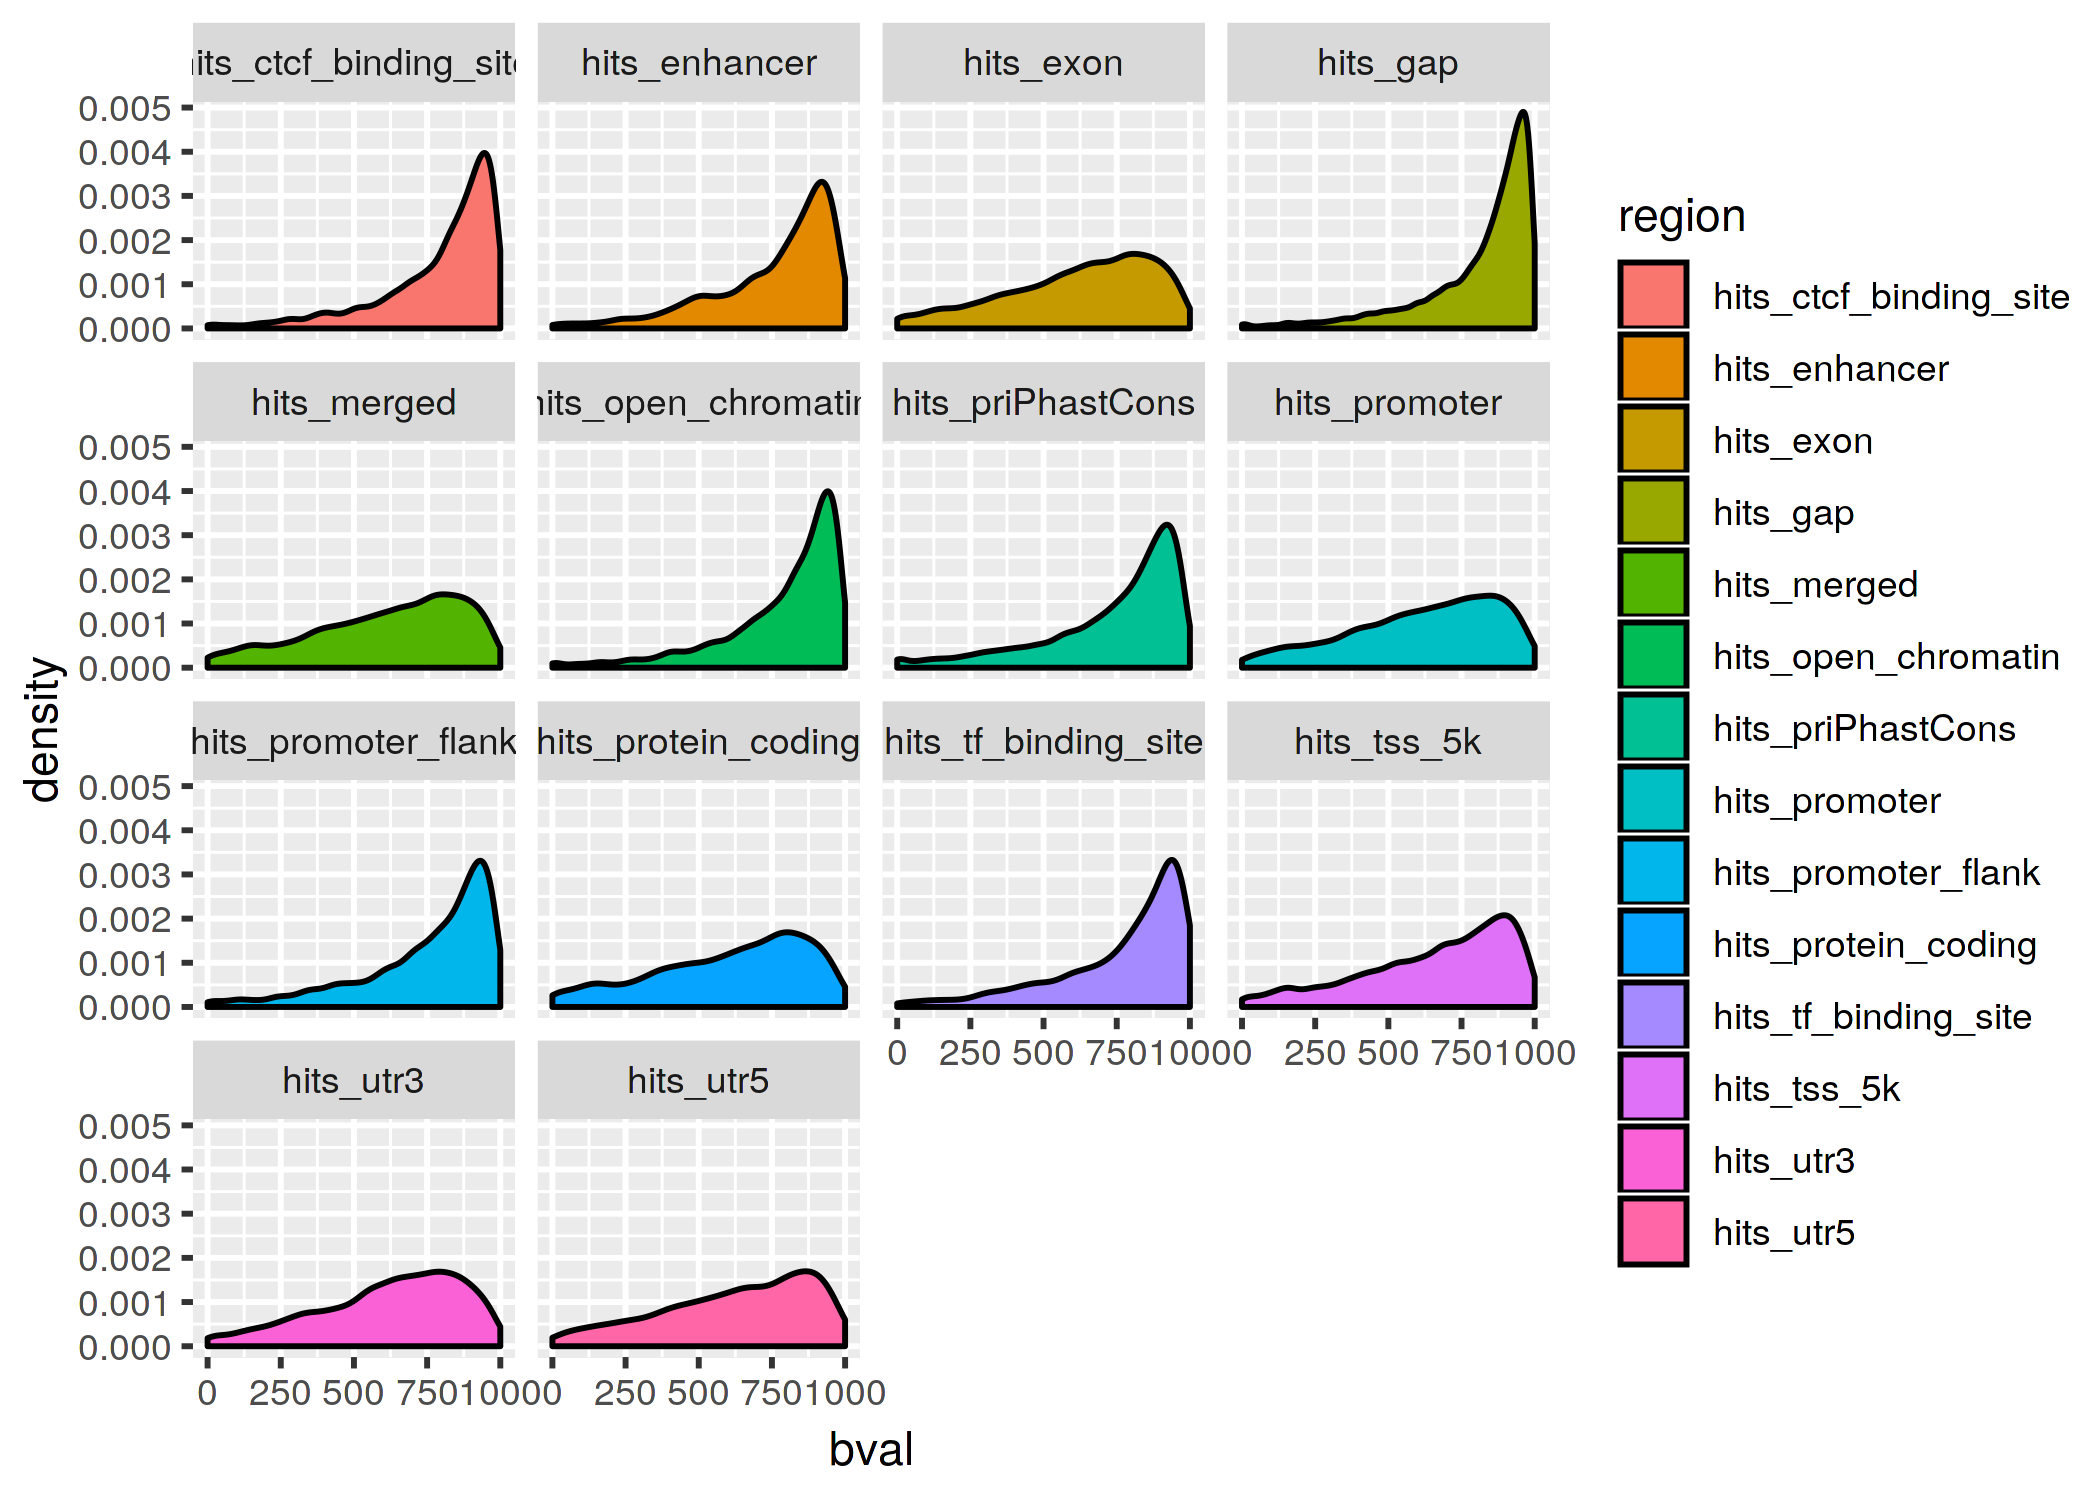

In [34]:
select(tbl, bval, starts_with("hits")) %>%
gather(region, hit, -bval) %>%
filter(hit == 1) %>%
ggplot(aes(bval, fill=region)) + geom_density() + facet_wrap(~ region)

It's clear from this that B values don't capture everything. Especially the `hits_priPhastCons` distribution looks very similar to others that don't show any selection against Neanderthal ancestry.

The regions that show the lowest average B value are also the ones that show some evidence of selection against Neanderthal ancestry. With the exception of protein coding regions and 5' UTRs which are not significantly depleted of Neanderthal ancestry.

On the other hand, TF binding regions do show an _increase_ in the Neanderthal ancestry proportion, but the B value distribution does not differ from the genome-wide distribution very much.

<br><br><br><br><br>

## Size of overlaps between all pairs of genomic regions

In [35]:
functional_regions <- setdiff(names(regions), "gap")

In [36]:
overlaps <- matrix(rep(NA, length(functional_regions) ^ 2), nrow=length(functional_regions))
colnames(overlaps) <- rownames(overlaps) <- functional_regions

In [37]:
for (r1 in functional_regions) {
    for (r2 in setdiff(functional_regions, r1)) {
        r1_gr <- regions[[r1]]
        r2_gr <- regions[[r2]]

        overlaps[r1, r2] <- sum(width(IRanges::intersect(r1_gr, r2_gr))) / sum(width(r1_gr)) 
    }
}

In [38]:
overlaps

,protein_coding,utr5,utr3,exon,tss_5k,ctcf_binding_site,enhancer,open_chromatin,promoter,promoter_flank,tf_binding_site,priPhastCons,merged
protein_coding,NA,0.049916021,0.17361906,1.00000000,0.15142917,0.02761974,2.893524e-03,0.0242140282,0.051009628,4.172217e-02,0.0113411820,0.61536838,0.988727632
utr5,0.163437583,NA,0.03876457,1.00000000,0.50055027,0.02933340,4.863457e-03,0.0185697922,0.401536277,8.569841e-02,0.0146414516,0.24409811,0.536336232
utr3,0.156824280,0.010693970,NA,1.00000000,0.10055220,0.02465764,6.548724e-03,0.0254803155,0.009075050,3.306343e-02,0.0087620752,0.25579652,0.164025403
exon,0.457656774,0.139774492,0.50666859,NA,0.17028028,0.02686245,4.963642e-03,0.0241716212,0.079343797,4.417307e-02,0.0105832187,0.37930091,0.508496793
tss_5k,0.032546608,0.032857303,0.02392610,0.07996881,NA,0.03550089,8.215018e-03,0.0190093200,0.080413857,4.842327e-02,0.0083184854,0.05863172,0.107569775
ctcf_binding_site,0.022672166,0.007354004,0.02240831,0.04818138,0.13558651,NA,1.488923e-02,0.0712938466,0.005935422,9.195244e-02,0.0498221721,0.05382236,0.027665739
enhancer,0.005358768,0.002750876,0.01342699,0.02008623,0.07078646,0.03359207,NA,0.0000000000,0.000000000,7.655305e-05,0.0000000000,0.08015083,0.005358768
open_chromatin,0.016004941,0.003748712,0.01864558,0.03491025,0.05845982,0.05740711,0.000000e+00,NA,0.000000000,3.903973e-04,0.0000000000,0.09872298,0.016004941
promoter,0.076098228,0.182951174,0.01498841,0.25863987,0.55815793,0.01078700,0.000000e+00,0.0000000000,NA,0.000000e+00,0.0000000000,0.15302011,1.000000000
promoter_flank,0.023632395,0.014825237,0.02073351,0.05467119,0.12761413,0.06344987,2.341346e-05,0.0003345497,0.000000000,NA,0.0003891253,0.08112098,0.023584095


<br><br><br><br><br><br><br><br><br><br>
## Export coordinates of genomic regions and their sites in BED format

In [39]:
df_to_bed <- function(df, path) {
    df %>%
        mutate(start=as.integer(start - 1), end=as.integer(end)) %>%
        write_tsv(path, col_names=FALSE)
}

In [40]:
dir.create("../data/bed/regions")

#### Regions (for later simulation of Genomic Elements in SLiM)

In [41]:
for (r in names(regions)) {
    regions[[r]] %>%
        as.data.frame %>%
        select(seqnames, start, end) %>%
        filter(end - start > 0) %>% # remove 1bp "regions"
        df_to_bed(file.path("../data/bed/regions", paste0(r, "_regions.bed")))
}

#### Sites (for later simulation of informative positions in SLiM)

In [42]:
for (r in names(regions)) {
    filter(tbl, tbl[paste0("hits_", r)] == 1) %>%
        select(chrom, start, end) %>%
        df_to_bed(file.path("../data/bed/regions", paste0(r, "_sites.bed")))
}

#### Regions and gap sites

These BED files will be used to calculate genetic distance between different regions and "gap sites".

In [43]:
gap_sites <- filter(tbl, hits_gap == 1) %>% makeGRangesFromDataFrame

for (r in names(regions)) {
    if (r == "gap") next # we don't care about gap regions

    regions_gr <- regions[[r]] %>% as.data.frame %>% filter(end - start > 0) %>% makeGRangesFromDataFrame
        
    c(regions_gr, gap_sites) %>%
        sort %>% 
        as.data.frame %>%
        select(seqnames, start, end) %>%
        mutate(seqnames=as.character(seqnames)) %>% 
        arrange(seqnames) %>%
        df_to_bed(file.path("../data/bed/regions", paste0(r, "_regions_gap_sites.bed")))
}

#### Coordinates of the filtered "fixed" sites from the admixture array

In [44]:
as.data.frame(sites) %>%
    select(seqnames, start, end) %>%
    mutate(seqnames=as.character(seqnames)) %>%
    df_to_bed(file.path("../data/bed/admixture_array_fixed.bed"))

In [45]:
save.image("../data/RData/introgression_predictors.RData")

### Generate a GRanges object with uniformly spaced positions of Neandertal markers

In [46]:
chrom_info <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)
seqlevels(chrom_info) <- paste0("chr", 1:22)

step_size <- 5000

unif_sites <- map(seqlevels(chrom_info), function(chrom) {
    GRanges(seqnames = chrom,
            IRanges(start = as.integer(seq(1, seqlengths(chrom_info)[chrom], by = step_size)), width = 1))
}) %>% GRangesList %>% unlist

In [47]:
for (r in names(regions)) {
    if (r == "gap") next # we don't care about gap regions

    regions_gr <- regions[[r]] %>% as.data.frame %>% filter(end - start > 0) %>% makeGRangesFromDataFrame

    # save merged regions and uniformly-spaced gap markers
    c(regions_gr, unif_sites[! unif_sites %over% regions_gr]) %>%
        sort %>% 
        as.data.frame %>%
        select(seqnames, start, end) %>%
        mutate(seqnames=as.character(seqnames)) %>% 
        arrange(seqnames) %>%
        df_to_bed(file.path("../data/bed/regions", paste0(r, "_unif_regions_gap_sites.bed")))
    
    # save uniformly-spaced markers within regions
    unif_sites[unif_sites %over% regions_gr] %>%
        sort %>% 
        as.data.frame %>%
        select(seqnames, start, end) %>%
        mutate(seqnames=as.character(seqnames)) %>%
        df_to_bed(file.path("../data/bed/regions", paste0(r, "_unif_sites.bed")))
}

## Admixture array proportions in different functional regions

In [48]:
sample_ids <- filter(samples, pop != "EMH")$name

combined <- inner_join(
    select(as.data.frame(sites), seqnames, start, end, contains("hits_")),
    select(as.data.frame(genotypes), seqnames, start, end, one_of(sample_ids))
)

nea_regions <- lapply(names(regions), function(r) {
    col <- paste0("hits_", r)
    hits <- select(tbl, chrom, start, col)

    filter(combined, complete.cases(hits)) %>%
        select(col, one_of(sample_ids)) %>%
        gather(region, hits, -c(S_Chane_1:S_Yemenite_Jew_2)) %>%
        gather(name, gt, -region, -hits) %>%
        group_by(name, region, hits) %>%
        summarise(nea=mean(gt, na.rm=TRUE) / 2) %>%
        ungroup %>%
        mutate(hits=factor(hits),
               region=str_replace(region, "hits_", ""))
}) %>% bind_rows

Joining, by = c("seqnames", "start", "end")


In [49]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,7671704,409.8,14114825,753.9,14114825,753.9
Vcells,373655599,2850.8,1150786370,8779.9,1438431464,10974.4


In [50]:
genome_nea <- inner_join(
    select(as.data.frame(sites), seqnames, start, end, contains("hits_")),
    select(as.data.frame(genotypes), seqnames, start, end, one_of(sample_ids))
) %>%
    summarise_at(sample_ids, function(i) { mean(i, na.rm=TRUE) / 2 }) %>%
    t %>% .[, 1]

Joining, by = c("seqnames", "start", "end")


In [51]:
median_region <- nea_regions %>% filter(hits == 1) %>% group_by(region) %>% summarise(med=median(nea)) %>% arrange(med)

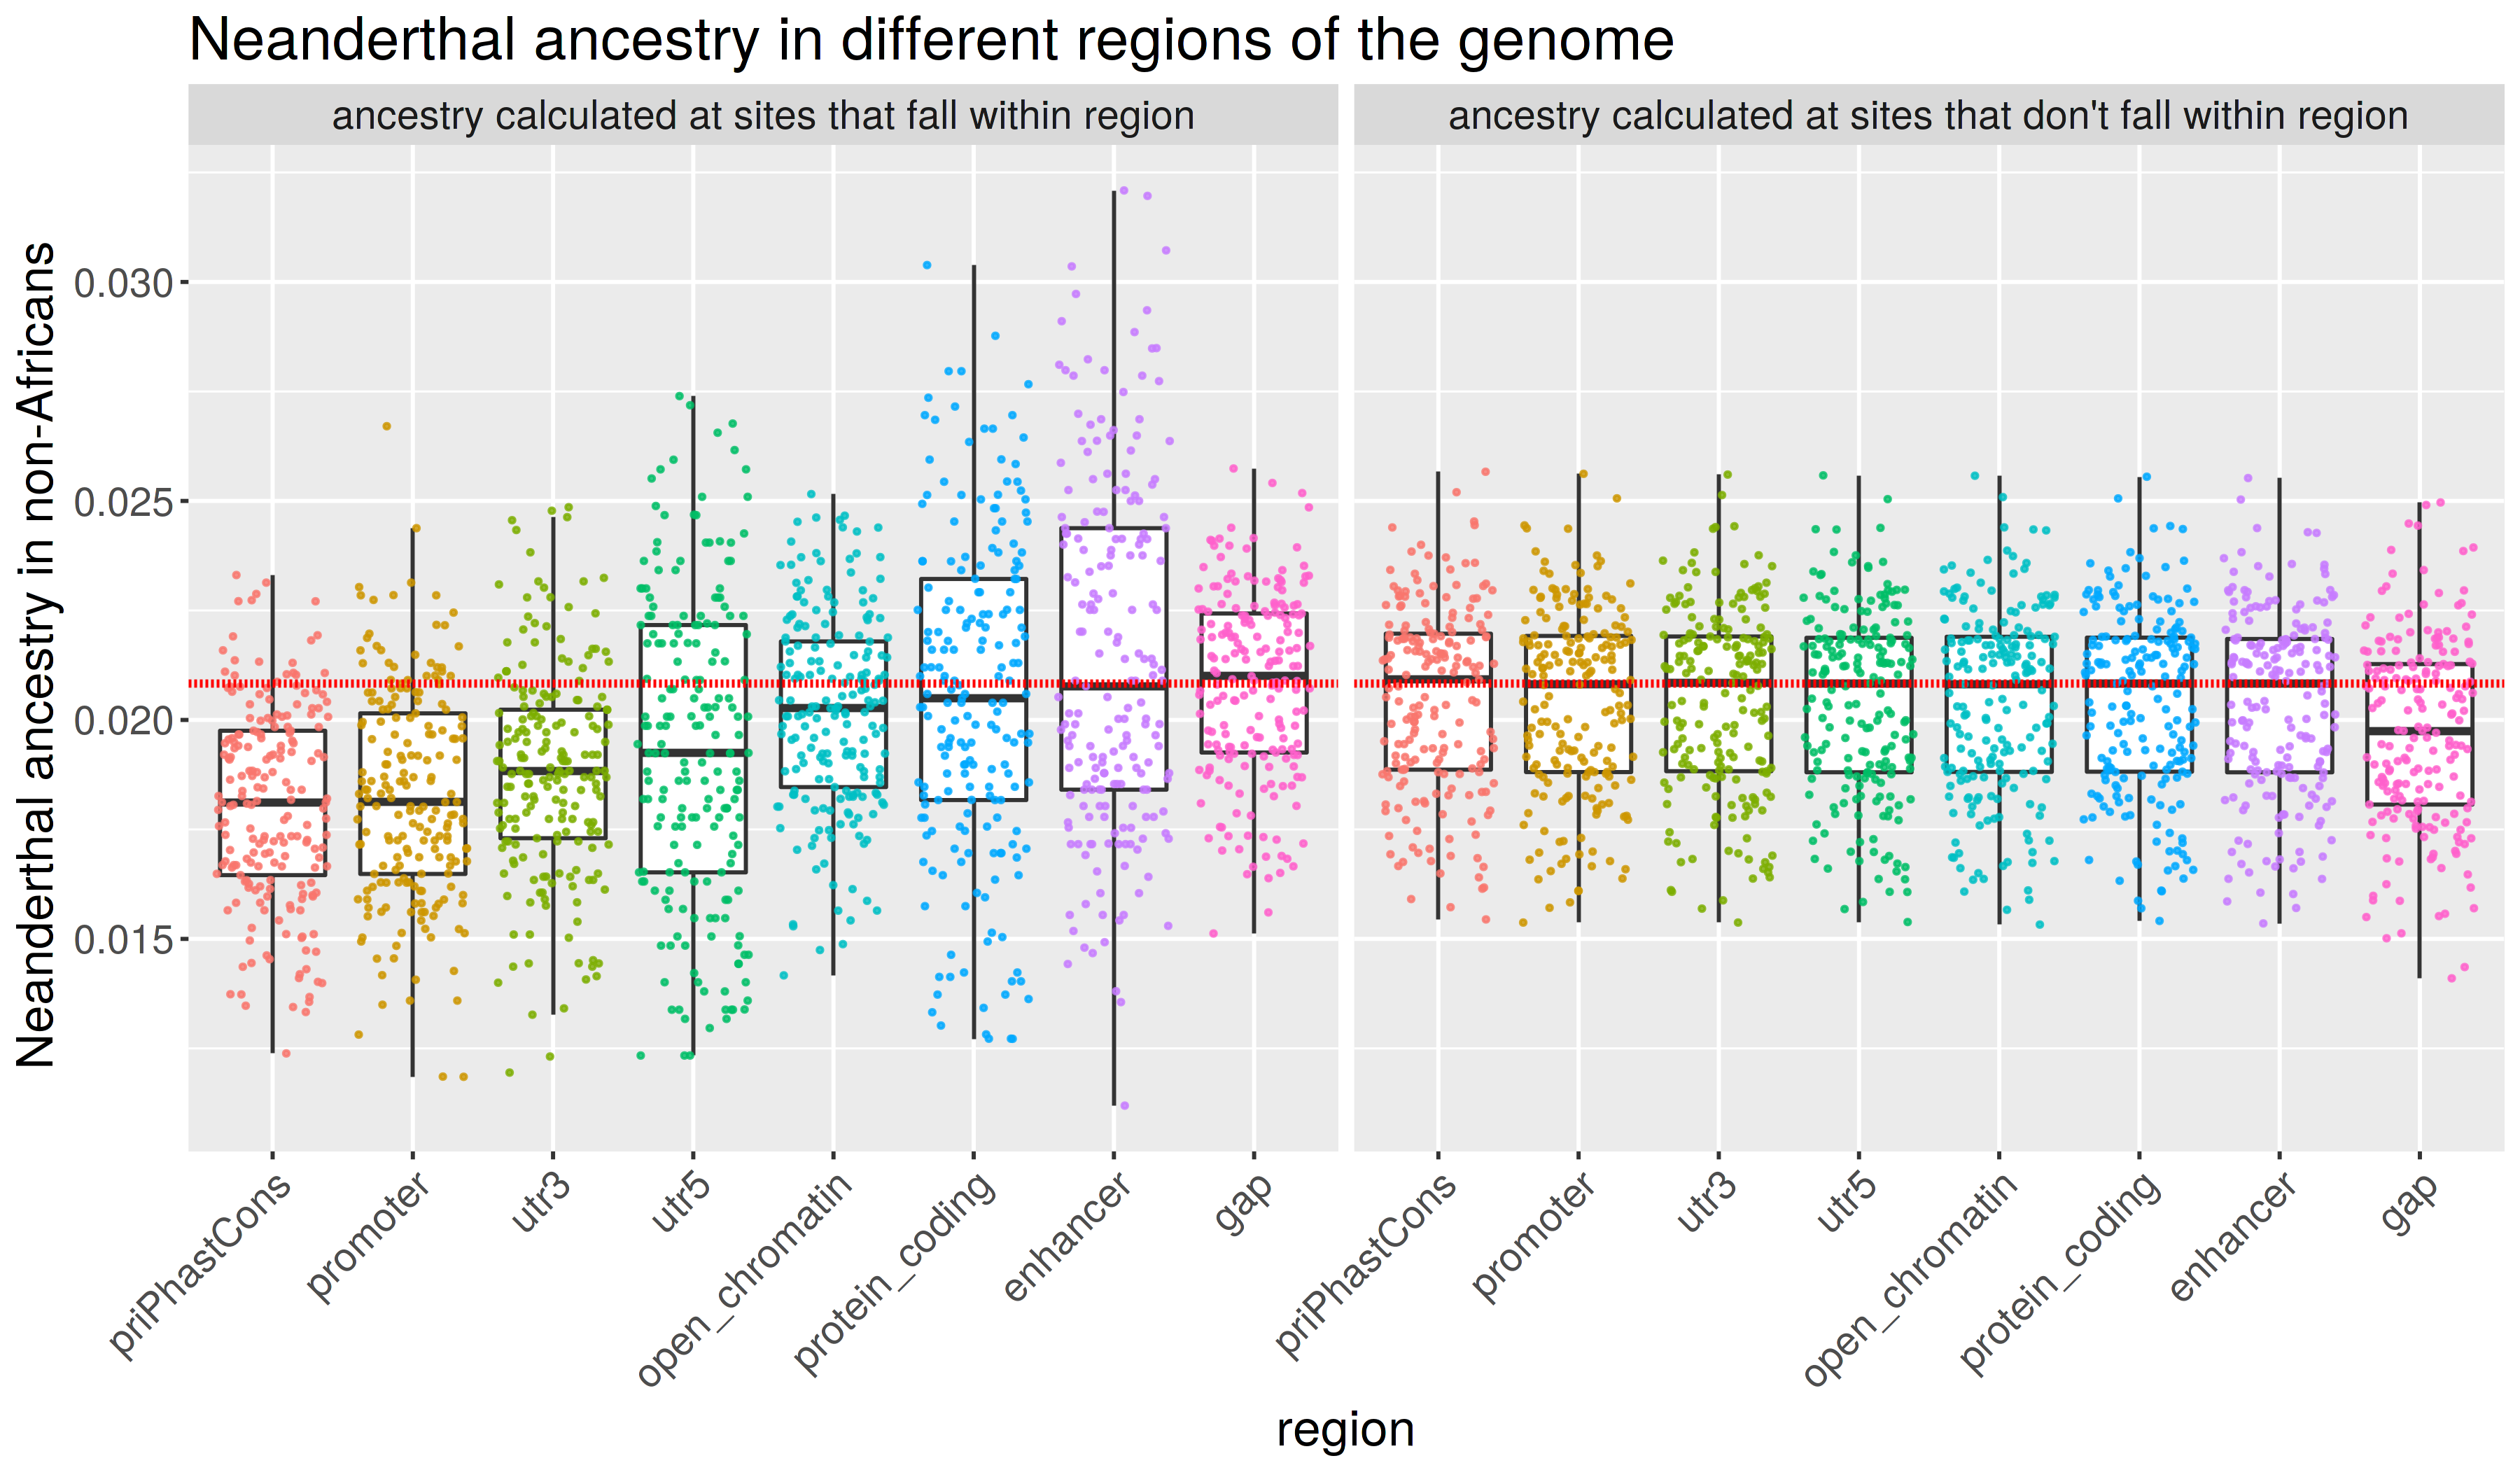

In [52]:
set_dim(12, 7, 300)

nea_regions %>% filter(region %in% c("priPhastCons", "promoter", "utr3", "utr5", "open_chromatin",
                                     "protein_coding", "enhancer", "gap")) %>%
mutate(hits=factor(ifelse(hits == 0, "ancestry calculated at sites that don't fall within region", "ancestry calculated at sites that fall within region"),
                   levels=c("ancestry calculated at sites that fall within region", "ancestry calculated at sites that don't fall within region")),
       region=factor(region, levels=median_region$region)) %>% 
ggplot(aes(region, nea)) +
    geom_boxplot(outlier.shape=NA) +
    geom_jitter(aes(color=region), size=0.5, alpha=0.8) +
    geom_hline(yintercept=median(genome_nea), linetype=2, color="red", size=1) +
    facet_grid(. ~ hits) +
    theme(text=element_text(size=17), axis.text.x=element_text(angle=45, hjust=1), legend.position="none") +
    ggtitle("Neanderthal ancestry in different regions of the genome") +
    labs(y="Neanderthal ancestry in non-Africans ", "genomic region")

# direct f4-ratio proportions in different functional regions

In [4]:
WGS_PREFIX <- here("data/eigenstrat/whole_genome/whole_genome")

In [5]:
snp <- read_snp(paste0(WGS_PREFIX, ".snp"))

In [6]:
snp_gr <- snp %>% 
    mutate(start = pos - 1) %>%
    select(chrom, start, end = pos) %>%
    makeGRangesFromDataFrame

In [7]:
ind <- read_ind(WGS_PREFIX %+% ".ind.individuals")

In [8]:
eigenstrat_samples <- 
    str_subset(ind$label,
               str_c(str_replace(sample_ids, "^S_", "") %>% str_replace("_\\d+$", "") %>% unique, collapse = "|"))

In [9]:
filter(samples, name %in% str_replace(eigenstrat_samples, "-", "_")) %>% nrow

[1] 197

Generate "badsnp" files:

In [52]:
for (bed_file in list.files(here("data/bed/regions"), ".*_regions.bed", full.names = TRUE)) {
    regions_gr <- import.bed(bed_file)
    seqlevels(regions_gr) <- str_replace(seqlevels(regions_gr), "chr", "")
    
    write_snp(
        WGS_PREFIX %+% "_badsnp_" %+% str_replace(basename(bed_file), "_regions.bed$", "") %+% ".snp",
        snp[!snp_gr %over% regions_gr, ]
    )
}

Calculate direct f4-ratio in each region for each European + East Asian:

In [10]:
badsnp_files <- list.files(here("data/eigenstrat/whole_genome/"), "*badsnp*", full.names = TRUE)

f4_regions <- mclapply(
    badsnp_files,
    function(badsnp_file) {
        f4ratio(
            X = eigenstrat_samples, A = "AltaiNeandertal", B = "Vindija33.19", C = "S_Dinka-1", O = "Chimp",
            prefix = WGS_PREFIX, ind = WGS_PREFIX %+% ".ind.individuals",
            badsnp = badsnp_file
        ) %>% mutate(region = str_replace_all(basename(badsnp_file), "whole_genome_badsnp_|.snp", ""))
    },
    mc.cores = 5
) %>% bind_rows

In [11]:
f4_median_region <- f4_regions %>% group_by(region) %>% summarise(alpha = median(alpha)) %>% arrange(alpha)

In [13]:
f4_genome_nea <- f4ratio(
    X = eigenstrat_samples, A = "AltaiNeandertal", B = "Vindija33.19", C = "S_Dinka-1", O = "Chimp",
    prefix = WGS_PREFIX, ind = WGS_PREFIX %+% ".ind.individuals"
)

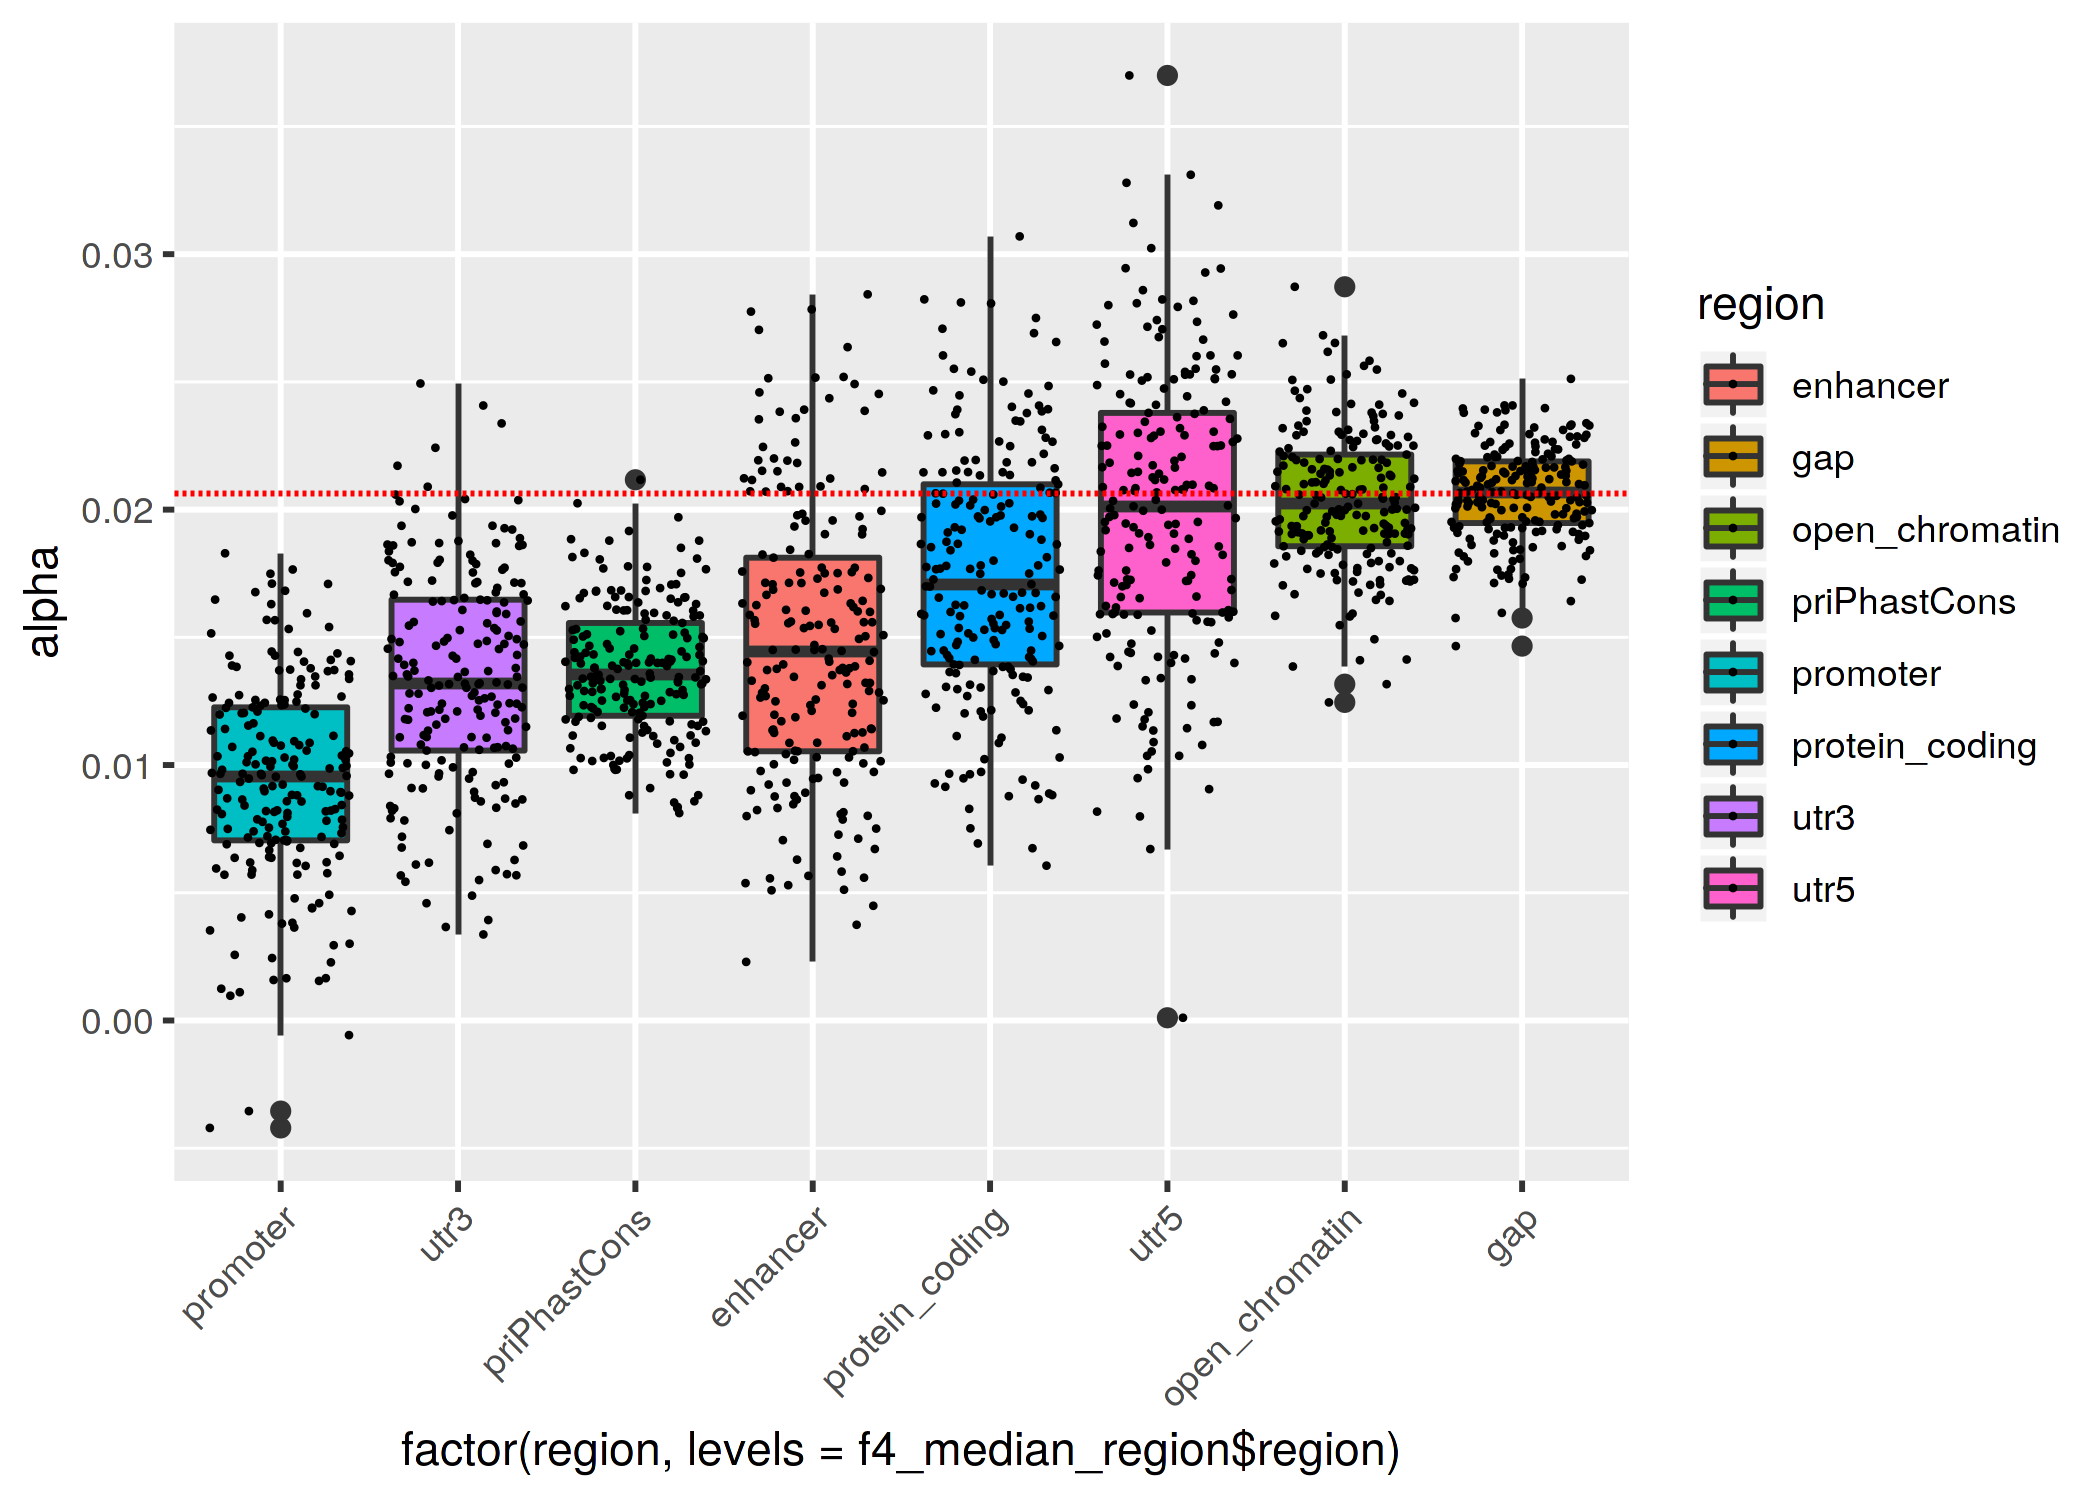

In [22]:
set_dim(7, 5, 300)

f4_regions %>%
filter(region %in% c("priPhastCons", "promoter", "utr3", "utr5", "open_chromatin",
                     "protein_coding", "enhancer", "gap")) %>%
ggplot(aes(factor(region, levels = f4_median_region$region), alpha, fill = region)) +
    geom_boxplot() + 
    geom_jitter(size = 0.1) +
    geom_hline(yintercept = median(f4_genome_nea$alpha), linetype = 2, color = "red") +
    theme(axis.text.x = element_text(hjust = 1, angle = 45))

In [15]:
saveRDS(f4_regions, here("data/rds/nea_in_genomic_regions.rds"))

In [16]:
f4_regions <- readRDS(here("data/rds/nea_in_genomic_regions.rds"))